In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

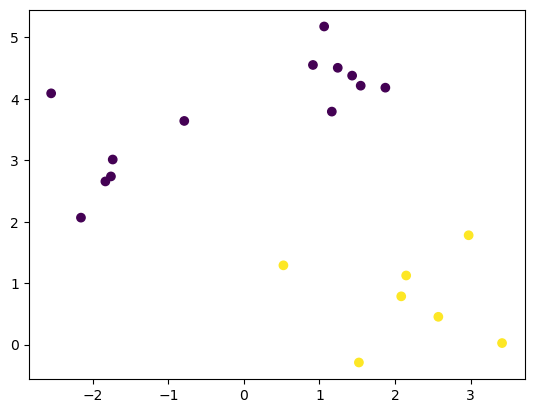

In [3]:
data_set_name = "toy-classification"
X, y_true = make_blobs(n_samples=20, centers=3, cluster_std=0.6, random_state=0)
y_true %= 2
y_true = y_true
plt.scatter(X[:, 0], X[:, 1], c=y_true)
plt.show()

In [8]:
cluster_annot_perfs = np.array(
    [[0.05, 0.95, 0.95, 0.05],
     [0.95, 0.05, 0.05, 0.95]]
)
random_state = np.random.RandomState(0)

In [10]:
def annot_sim_clf_cluster(
    X,
    y_true,
    cluster_annot_perfs,
    k_means_dict=None,
    random_state=None,
):
    """
    The knowledge of annotators is separated into clusters, where on each cluster an annotator can have different
    performances. These performances are expressed through labeling accuracies. The clusters are determined through a
    k-means algorithm.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Samples of the whole data set.
    y_true : array-like, shape (n_samples)
        True class labels of the given samples X.
    cluster_annot_perfs : array-like of shape (n_annotators, n_clusters)
        The entry `cluster_annot_perfs[j, i]` indicates the accuracy of annotator `j` for labeling samples of
        cluster `i`.
    k_means_dict : None or dict, optional (default=None)
        Dictionary of parameters that are passed to `sklearn.cluster.MiniBatchKMeans`.
    random_state : None or int or numpy.random.RandomState, optional (default=None)
        The random state used for drawing the annotations and specifying the clusters.

    Returns
    -------
    y : np.ndarray of shape (n_samples, n_annotators)
        Class labels of simulated annotators.
    """
    n_samples = X.shape[0]
    
    if np.sum(cluster_annot_perfs < 0) or np.sum(cluster_annot_perfs > 1):
        raise ValueError("`cluster_perfs` must contain values in [0, 1]")
    n_annotators = cluster_annot_perfs.shape[0]
    n_clusters = cluster_annot_perfs.shape[1]

    # Check `k_means_dict`.
    if k_means_dict is None:
        k_means_dict = {
            "batch_size": 2 ** 13,
            "random_state": random_state,
            "max_iter": 1000,
            "n_init": 10,
        }

    # Transform class labels to interval [0, n_classes-1].
    le = LabelEncoder().fit(y_true)
    y_true = le.transform(y_true)
    print("y_true", y_true)
    n_classes = len(le.classes_)

    # Compute clustering.
    y_cluster = MiniBatchKMeans(n_clusters=n_clusters, **k_means_dict).fit_predict(X)
    print("y_cluster", y_cluster)
    # shape is (n_samples, )

    # Simulate annotators.
    y = np.empty((n_samples, n_annotators)) # with shape (n_samples, n_annotators)
    for a_idx in range(n_annotators):
        P_predict = np.empty((n_samples, n_classes))
        for c_idx in range(n_clusters):
            print("c_idx", c_idx)
            is_c = y_cluster == c_idx
            p = (1 - cluster_annot_perfs[a_idx, c_idx]) / (n_classes - 1) # for wrong choose
            P_predict[is_c] = p
            P_predict[is_c, y_true[is_c]] = cluster_annot_perfs[a_idx, c_idx]
        cumlative = P_predict.cumsum(axis=1) # the row wise comlative sum (n_samples, n_classes)
        uniform = random_state.rand(len(cumlative), 1)
        # a matrix with shape (n_samples, 1) with value randomly form 0 to 1
        y_predict = (uniform < cumlative).argmax(axis=1)
        y[:, a_idx] = le.inverse_transform(y_predict)

    return y, y_cluster

In [11]:
annot_sim_clf_cluster(X, y_true, cluster_annot_perfs, random_state=random_state)

y_true [0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 0]
y_cluster [0 2 0 1 1 2 3 1 0 0 1 0 1 1 0 2 2 2 1 0]
c_idx 0
c_idx 1
c_idx 2
c_idx 3
c_idx 0
c_idx 1
c_idx 2
c_idx 3


(array([[1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]]),
 array([0, 2, 0, 1, 1, 2, 3, 1, 0, 0, 1, 0, 1, 1, 0, 2, 2, 2, 1, 0],
       dtype=int32))